# Load Spatial Data and Merge with R Data for Modeling
Prep data for R modeling

## Download Spatial Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import pysal as ps
import geopandas as gpd
import libpysal as lps
import sys
import platform
import zipfile
import os
from datetime import datetime

print(sys.version_info)
print("Python Version: " + str(platform.python_version()))

sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
Python Version: 3.7.3


/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
from census import Census
from us import states
import config

In [3]:
c = Census(config.api_secret)

In [4]:
!!states CA

['/bin/bash: states: command not found']

In [5]:
#!!wget https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_06_tract10.zip

In [6]:
params = {'legend.fontsize': 20}
plt.rcParams.update(params)
tfs = 20

In [7]:
import geopandas as gpd
shapefile0 = gpd.read_file("tl_2010_06_tract10/tl_2010_06_tract10.shp")
shapefile = shapefile0.query("COUNTYFP10=='075' and ALAND10>0") # grab tracts with land 
shapefile.index = list(range(shapefile.shape[0])) # GEOID10 is match with R 
shapefile.head(5)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,06,075,016500,06075016500,165,Census Tract 165,G5020,S,370459,0,+37.7741958,-122.4477884,"POLYGON ((-122.446471 37.775802, -122.44478 37..."
1,06,075,016400,06075016400,164,Census Tract 164,G5020,S,309097,0,+37.7750995,-122.4369729,"POLYGON ((-122.44034 37.77658, -122.439844 37...."
2,06,075,016300,06075016300,163,Census Tract 163,G5020,S,245867,0,+37.7760456,-122.4295509,"POLYGON ((-122.429152 37.778007, -122.428909 3..."
3,06,075,016100,06075016100,161,Census Tract 161,G5020,S,368901,0,+37.7799831,-122.4286631,"POLYGON ((-122.428909 37.778039, -122.429152 3..."
4,06,075,016000,06075016000,160,Census Tract 160,G5020,S,158236,0,+37.7823363,-122.4224838,"POLYGON ((-122.420425 37.780583, -122.420336 3..."


In [8]:
shapefile.shape

(196, 13)

In [9]:
clean_sf_tracts_link = "tl_2010_06_tract10/sf_census_tracts_basic"
clean_sf_shp = clean_sf_tracts_link + ".shp"
shapefile = gpd.GeoDataFrame(shapefile)
shapefile.to_file(clean_sf_shp)

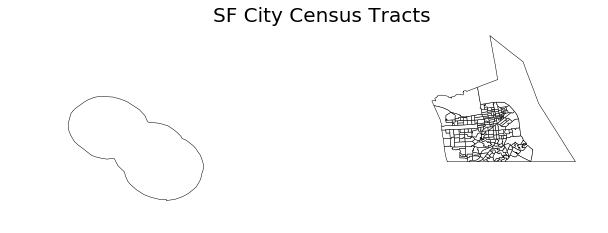

In [10]:
f, ax = plt.subplots(1, figsize=(10, 10))
shapefile.plot(ax=ax, linewidth=0.5, color='white', edgecolor='black')
plt.title('SF City Census Tracts', fontsize=tfs)
ax.set_axis_off()
plt.show()

### Understand Neighbors and Geospatial Relationships
Clean Outliers and from http://andrewgaidus.com/Spatial_Econonometric_Modeling/

In [11]:
## need to add data and then can run this
shapefile = shapefile.set_index('GEOID10')
qW = lps.weights.Queen.from_shapefile(clean_sf_shp, 'GEOID10')
rW = lps.weights.Rook.from_shapefile(clean_sf_shp, 'GEOID10')
bW = lps.weights.w_difference(qW, rW, constrained=False) 

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/contiguity.py:184: UserWarning: There is one disconnected observation (no neighbors).
Island id: 06075980401
  W.__init__(self, neighbors, ids=ids, **kw)
/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/contiguity.py:34: UserWarning: There is one disconnected observation (no neighbors).
Island id: 06075980401
  W.__init__(self, neighbors, ids=ids, **kw)
/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 91 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 0

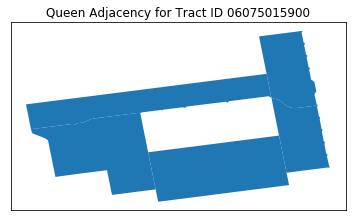

In [12]:
def plot_queen_neighbors(geoid, queen_matrix, data):
    queen_neighs=queen_matrix.neighbors[geoid]
    q=data.loc[queen_neighs].plot()
    q.set_xticks([])
    q.set_yticks([])
    title=plt.title('Queen Adjacency for Tract ID ' + geoid)
    
plot_queen_neighbors(geoid='06075015900', queen_matrix=qW, data=shapefile)

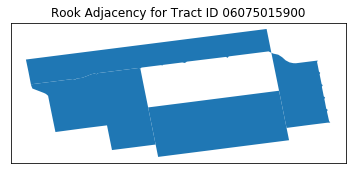

In [13]:
def plot_rook_neighbors(geoid, rook_matrix, data):
    rook_neighs=rook_matrix.neighbors[geoid]
    q=data.loc[rook_neighs].plot()
    q.set_xticks([])
    q.set_yticks([])
    title=plt.title('Rook Adjacency for Tract ID ' + geoid)
    
plot_rook_neighbors(geoid='06075015900', rook_matrix=rW, data=shapefile)

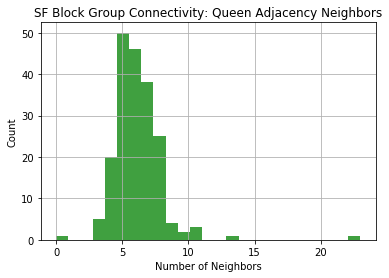

In [14]:
n, bins, patches = plt.hist(qW.cardinalities.values(), 25, facecolor='green', alpha=0.75)

plt.xlabel('Number of Neighbors')
plt.ylabel('Count')
plt.title('SF Block Group Connectivity: Queen Adjacency Neighbors')
plt.grid(True)

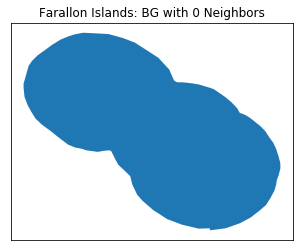

In [15]:
islandid=[k for k,v in qW.cardinalities.items() if v==0][0]
p=gpd.GeoSeries(shapefile.loc[islandid]).plot()
s=p.set_xticks([])
s=p.set_yticks([])
title=plt.title('Farallon Islands: BG with 0 Neighbors')

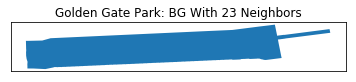

In [16]:
idmax=pd.Series(qW.cardinalities).idxmax()
p=shapefile.loc[[idmax]].plot()
s=p.set_xticks([])
s=p.set_yticks([])
title=plt.title('Golden Gate Park: BG With ' +  str(len(qW.neighbors[idmax])) + ' Neighbors')

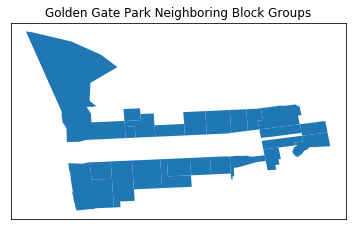

In [17]:
neigh_ids=qW.neighbors[idmax]
p=shapefile.loc[neigh_ids].plot()
s=p.set_xticks([])
s=p.set_yticks([])
title=plt.title('Golden Gate Park Neighboring Block Groups')

In [18]:
clean_sf_link = '../../data/clean_sf_tracts'
clean_sf_shp = clean_sf_link + '.shp'
shapefile_clean = shapefile[~shapefile.index.isin([islandid])].reset_index() #[idmax, islandid])] 
print(shapefile_clean.shape)
# drop golden gate parkr and island...or maybe just keep for now

(195, 13)


In [19]:
shapefile_clean.head(5)

,GEOID10,STATEFP10,COUNTYFP10,TRACTCE10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,06075016500,06,075,016500,165,Census Tract 165,G5020,S,370459,0,+37.7741958,-122.4477884,"POLYGON ((-122.446471 37.775802, -122.44478 37..."
1,06075016400,06,075,016400,164,Census Tract 164,G5020,S,309097,0,+37.7750995,-122.4369729,"POLYGON ((-122.44034 37.77658, -122.439844 37...."
2,06075016300,06,075,016300,163,Census Tract 163,G5020,S,245867,0,+37.7760456,-122.4295509,"POLYGON ((-122.429152 37.778007, -122.428909 3..."
3,06075016100,06,075,016100,161,Census Tract 161,G5020,S,368901,0,+37.7799831,-122.4286631,"POLYGON ((-122.428909 37.778039, -122.429152 3..."
4,06075016000,06,075,016000,160,Census Tract 160,G5020,S,158236,0,+37.7823363,-122.4224838,"POLYGON ((-122.420425 37.780583, -122.420336 3..."


In [20]:
shapefile_clean = gpd.GeoDataFrame(shapefile_clean)
shapefile_clean.to_file(clean_sf_shp)

## Code to Add Additional Data 

## Create Data for Clean Approach

In [21]:
data_file = '../../data/crime_with_census_ids.csv'
crime_data = pd.read_csv(data_file, dtype={'GEOID_tract':'str', 'GEOID_block':'str'})
print(crime_data.shape)
crime_data.head()

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (14,15,19,20,21,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1317984, 35)


,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,lng,...,AnalysisNeighborhood,SupervisorDistrict,month,day,CatDesc,marijuana,meth,opium,GEOID_tract,GEOID_block
0,100089281,ASSAULT,BATTERY,Tuesday,2010-01-26,00:01:00,INGLESIDE,NONE,600 Block of VELASCO AV,-122.418064,...,NaN,NaN,1,26,BlueCollar,0,0,0,06075026404,060750264041
1,100218399,ASSAULT,BATTERY,Sunday,2010-03-07,03:10:00,SOUTHERN,NONE,200 Block of 10TH ST,-122.413532,...,NaN,NaN,3,7,BlueCollar,0,0,0,06075017802,060750178022
2,101000400,ASSAULT,BATTERY,Wednesday,2010-10-27,22:00:00,MISSION,NONE,1000 Block of POTRERO AV,-122.406539,...,NaN,NaN,10,27,BlueCollar,0,0,0,06075022802,060750228022
3,100604550,RUNAWAY,RUNAWAY,Thursday,2010-07-01,11:39:00,MISSION,LOCATED,1100 Block of POTRERO AV,-122.406463,...,NaN,NaN,7,1,Other,0,0,0,06075022903,060750229031
4,100807237,ASSAULT,BATTERY,Wednesday,2010-09-01,19:33:00,TARAVAL,NONE,2600 Block of 47TH AV,-122.505399,...,NaN,NaN,9,1,BlueCollar,0,0,0,06075035400,060750354005


In [22]:
grouped_crime= crime_data[['year','GEOID_tract','Date']].groupby(['year','GEOID_tract']).count().reset_index()
grouped_crime.columns.values[2] = 'crime_count'
grouped_crime.head(5)

,year,GEOID_tract,crime_count
0,2010,06075010100,1604
1,2010,06075010200,823
2,2010,06075010300,234
3,2010,06075010400,289
4,2010,06075010500,1096


In [23]:
census_files = '../../data/census_tract_2009_2017.csv'
census_data = pd.read_csv(census_files, dtype={'GEOID':'str', 'year': 'int'})
census_data['GEOID'] = [g.rjust(11, '0') for g in census_data['GEOID']]
census_data.head(5)

,GEOID,NAME,year,Estimate_Total,Female,Female_10_to_14_years,Female_10th_grade,Female_11th_grade,Female_12th_grade_no_diploma,Female_15_to_17_years,...,Same_house_1_year_ago_Male,With_income,With_income_1_to_9999_or_loss,With_income_10000_to_14999,With_income_15000_to_24999,With_income_25000_to_34999,With_income_35000_to_49999,With_income_50000_to_64999,With_income_65000_to_74999,With_income_75000_or_more
0,06075010100,"Census Tract 101, San Francisco County, Califo...",2009,3685.0,1737.0,46,42,13,17,65,...,1500.0,2963.0,504,296,356.0,167,547,395,92,606.0
1,06075010100,"Census Tract 101, San Francisco County, Califo...",2010,3744.0,1927.0,40,34,14,10,61,...,1464.0,3117.0,496,354,342.0,131,562,351,231,650.0
2,06075010100,"Census Tract 101, San Francisco County, Califo...",2011,3851.0,1890.0,60,0,13,20,86,...,1567.0,3172.0,410,383,506.0,149,437,413,205,669.0
3,06075010100,"Census Tract 101, San Francisco County, Califo...",2012,3598.0,1662.0,28,0,0,17,39,...,1430.0,3008.0,392,407,425.0,175,365,337,162,745.0
4,06075010100,"Census Tract 101, San Francisco County, Califo...",2013,3741.0,1690.0,27,0,0,12,14,...,1367.0,3127.0,340,380,498.0,190,364,309,172,874.0


In [24]:
all_data = grouped_crime.merge( census_data, how='left', left_on=['GEOID_tract', 'year'], right_on=['GEOID', 'year'])
all_data['rate'] = all_data['crime_count'] / all_data['Estimate_Total']
all_data['log_rate'] = np.log(all_data['rate'])
all_data = all_data[np.isfinite(all_data['log_rate'])] # keep rows where log_rate isnt NA
all_data = all_data.fillna(0) # now fill all other columns with 0 
print(all_data.shape)
all_data.head(5)

(1560, 155)


,year,GEOID_tract,crime_count,GEOID,NAME,Estimate_Total,Female,Female_10_to_14_years,Female_10th_grade,Female_11th_grade,...,With_income_1_to_9999_or_loss,With_income_10000_to_14999,With_income_15000_to_24999,With_income_25000_to_34999,With_income_35000_to_49999,With_income_50000_to_64999,With_income_65000_to_74999,With_income_75000_or_more,rate,log_rate
0,2010,06075010100,1604,06075010100,"Census Tract 101, San Francisco County, Califo...",3744.0,1927.0,40.0,34.0,14.0,...,496.0,354.0,342.0,131.0,562.0,351.0,231.0,650.0,0.428419,-0.847654
1,2010,06075010200,823,06075010200,"Census Tract 102, San Francisco County, Califo...",4184.0,2201.0,0.0,0.0,12.0,...,239.0,172.0,222.0,446.0,395.0,322.0,232.0,1631.0,0.196702,-1.626067
2,2010,06075010300,234,06075010300,"Census Tract 103, San Francisco County, Califo...",4285.0,2135.0,49.0,26.0,21.0,...,488.0,231.0,317.0,233.0,510.0,375.0,133.0,1161.0,0.054609,-2.907555
3,2010,06075010400,289,06075010400,"Census Tract 104, San Francisco County, Califo...",4154.0,2205.0,73.0,15.0,41.0,...,369.0,172.0,405.0,259.0,551.0,659.0,157.0,1165.0,0.069571,-2.665400
4,2010,06075010500,1096,06075010500,"Census Tract 105, San Francisco County, Califo...",2429.0,1214.0,0.0,0.0,0.0,...,160.0,235.0,209.0,61.0,79.0,187.0,78.0,1246.0,0.451214,-0.795812


In [25]:
shape_file_data = pd.merge(shapefile, all_data, left_on='GEOID10', right_on='GEOID', how='inner')
shape_file_data.head(1).T

,0
STATEFP10,06
COUNTYFP10,075
TRACTCE10,016500
NAME10,165
NAMELSAD10,Census Tract 165
MTFCC10,G5020
FUNCSTAT10,S
ALAND10,370459
AWATER10,0
INTPTLAT10,+37.7741958


In [26]:
shape_file_data['year'] = shape_file_data['year'].astype('int')

## Modeling 
1. load the data
2. create basic model

In [27]:
from pysal.explore.esda.moran import Moran

def create_shp_year(data, year, location, fn):
    clean_sf_link = location + fn + str(year)
    clean_sf_shp = clean_sf_link + '.shp'
    data0 = data.query('year==@year').reset_index()
    data0 = data0.drop('index', axis=1)
    shaped_data = gpd.GeoDataFrame(data0)
    shaped_data.to_file(clean_sf_shp)
    return(data0)

In [28]:
def create_neighbors(shape_file_location):
    qW = lps.weights.Queen.from_shapefile(shape_file_location, 'GEOID')
    qW.transform='r'
    rW = lps.weights.Rook.from_shapefile(shape_file_location, 'GEOID')
    rW.transform='r'
    bW = lps.weights.w_difference(qW, rW, constrained=False) 
    bW.transform='r'
    return qW, rW, bW

In [29]:
def basic_analysis(start_year, end_year, data, location, fn):
    dict_data = {}
    morans_data = pd.DataFrame()
    for y in range(start_year, end_year+1):
        print('starting year ' + str(y))
        data_yr = create_shp_year(data, int(y), location, fn)
        qW, rW, bW = create_neighbors(location + fn + str(y) + '.shp')
        for weight_type, w in zip(['queen','rook','bishop'], [qW, rW, bW]):
            ## get Moran data for all combos and weights...
            mi = Moran(y= np.array(data_yr['log_rate']), w=w)
            morans_data = morans_data.append({'year': y, 'weight':weight_type, 'moran_i':mi.I, 
                                   'moran_z': mi.z_norm, 'moran_p':mi.p_norm}, ignore_index=True)
        dict_data[y] = {'data':data_yr, 'qW':qW, 'rW':rW, 'bW':bW}
        
    return(dict_data, morans_data)

In [30]:
yearly_data, morans_data = basic_analysis(2010, 2017, 
                                          shape_file_data, 
                                          '../../data/', 
                                          'clean_sf_tracts_with_features_')

starting year 2010


/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

In [31]:
morans_data.head(5)

,moran_i,moran_p,moran_z,weight,year
0,0.185923,2.722477e-06,4.690718,queen,2010.0
1,0.194691,4.614492e-06,4.581592,rook,2010.0
2,0.111512,3.260446e-01,0.982112,bishop,2010.0
3,0.200841,4.260232e-07,5.056946,queen,2011.0
4,0.211936,6.459280e-07,4.976954,rook,2011.0


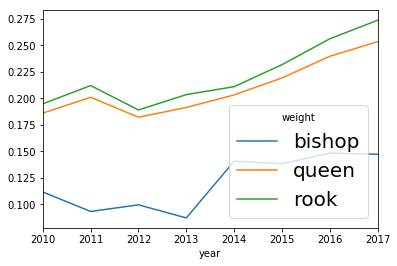

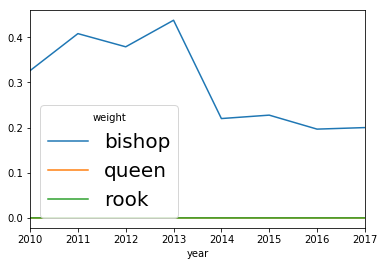

In [32]:
#morans_data.groupby('weight').plot(x='year', y='moran_i')
pd.pivot_table(morans_data, values='moran_i', columns='weight', index='year').plot()
pd.pivot_table(morans_data, values='moran_p', columns='weight', index='year').plot()

In [33]:
# knn = lps.weights.KNN.from_shapefile(clean_shp_link, k=4)
# self_and_neighbors = [0]
# self_and_neighbors.extend(knn.neighbors[0])
# print(self_and_neighbors)

In [34]:
from pysal.model import *
def simple_model(year):
    tmp_data = yearly_data[year]['data']
    y = np.array(tmp_data['log_rate'])
    y = np.resize(y, [len(y), 1])
    x = np.array(tmp_data[['Estimate_Total']])
    qW = yearly_data[year]['qW']
    model = spreg.OLS(y, x, w=qW, name_y='log rate change', 
                      name_x=['Estimate_Total'],
                      name_ds='censusdata')
    return(model)
    

In [35]:
print(simple_model(2016).summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :  censusdata
Weights matrix      :     unknown
Dependent Variable  :log rate change                Number of Observations:         195
Mean dependent var  :     -2.0447                Number of Variables   :           2
S.D. dependent var  :      0.9413                Degrees of Freedom    :         193
R-squared           :      0.0766
Adjusted R-squared  :      0.0718
Sum squared residual:     158.743                F-statistic           :     16.0054
Sigma-square        :       0.823                Prob(F-statistic)     :   8.995e-05
S.E. of regression  :       0.907                Log likelihood        :    -256.636
Sigma-square ML     :       0.814                Akaike info criterion :     517.272
S.E of regression ML:      0.9023                Schwarz criterion     :     523.818

--------------------------------------------------------------------------

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/pysal/model/spreg/user_output.py:456: UserWarning: w must be API-compatible pysal weights object
  warn("w must be API-compatible pysal weights object")


## find differrrent variables thru RF

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


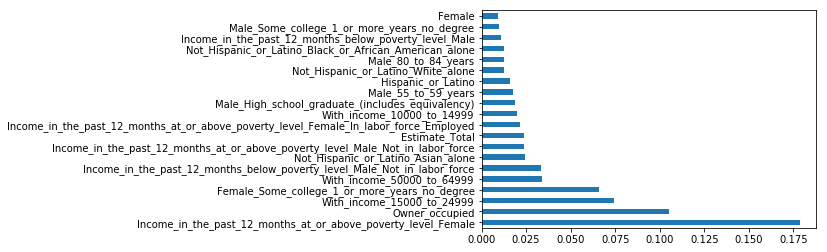

In [36]:
from sklearn.ensemble import RandomForestRegressor

y = shape_file_data['log_rate']
x = shape_file_data.select_dtypes(exclude=['object'])
x = x.drop(['ALAND10', 'AWATER10','crime_count','rate', 'log_rate'], axis=1)

rf_tree = RandomForestRegressor(random_state=0)  
rf_tree.fit(x, y)  

feat_importances = pd.Series(rf_tree.feature_importances_, index=x.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [37]:
new_vars = list(feat_importances.nlargest(20).index)
def complex_model(year, cols):
    tmp_data = yearly_data[year]['data']
    y = np.array(tmp_data['log_rate'])
    y = np.resize(y, [len(y), 1])
    x = np.array(tmp_data[cols])
    qW = yearly_data[year]['qW']
    model = spreg.OLS(y, x, w=qW, name_y='log rate change', 
                      name_x=cols,
                      name_ds='censusdata')
    return(model)
    
m_complex = complex_model(2016, new_vars)
print(m_complex.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :  censusdata
Weights matrix      :     unknown
Dependent Variable  :log rate change                Number of Observations:         195
Mean dependent var  :     -2.0447                Number of Variables   :          21
S.D. dependent var  :      0.9413                Degrees of Freedom    :         174
R-squared           :      0.3814
Adjusted R-squared  :      0.3103
Sum squared residual:     106.339                F-statistic           :      5.3643
Sigma-square        :       0.611                Prob(F-statistic)     :   1.879e-10
S.E. of regression  :       0.782                Log likelihood        :    -217.573
Sigma-square ML     :       0.545                Akaike info criterion :     477.145
S.E of regression ML:      0.7385                Schwarz criterion     :     545.878

--------------------------------------------------------------------------

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/pysal/model/spreg/user_output.py:456: UserWarning: w must be API-compatible pysal weights object
  warn("w must be API-compatible pysal weights object")


In [38]:
malvika_url = "https://raw.githubusercontent.com/malvikarajeev/sfcrimeanalysis/master/weekly_crime_counts_with_varaibles.csv"
addtl_data = pd.read_csv(malvika_url, index_col=0)
addtl_data['GEOID'] = [str(g).rjust(11, '0') for g in addtl_data['GEOID']]
addtl_data.head(5)

,year,GEOID,week,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class
1,2010,06075010100,1,34,4,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
2,2010,06075010100,2,29,9,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
3,2010,06075010100,3,21,6,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
4,2010,06075010100,4,21,15,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
5,2010,06075010100,5,22,6,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472


In [39]:
yearly_agg_data = addtl_data[['year','GEOID','N','N_calls_311']].groupby(['year','GEOID']).sum().reset_index()
yearly_agg_data.head(5)

,year,GEOID,N,N_calls_311
0,2010,06075010100,1604,600
1,2010,06075010200,823,634
2,2010,06075010300,234,445
3,2010,06075010400,289,599
4,2010,06075010500,1096,663


In [40]:
census_vars = addtl_data.drop(['week','N','N_calls_311'], axis=1).groupby(['year','GEOID']).mean().reset_index()
census_vars.head(5)

,year,GEOID,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class
0,2010,06075010100,3744,0.337502,0.485310,0.936699,0.795406,0.080802,0.199252,565,1564.120200,528.96,0.503472
1,2010,06075010200,4184,0.362643,0.473948,0.885038,0.950765,0.438360,0.173757,444,2667.206779,747.13,0.352294
2,2010,06075010300,4285,0.354192,0.501750,0.944457,0.808401,0.213598,0.275613,109,1868.883223,648.90,0.415169
3,2010,06075010400,4154,0.377667,0.469186,0.931873,0.949446,0.315683,0.206548,122,2640.336721,750.38,0.422725
4,2010,06075010500,2429,0.378550,0.500206,0.942775,0.940716,0.286248,0.217373,45,1513.915619,458.53,0.306299


In [41]:
yearly_data2 = yearly_agg_data.merge(census_vars, left_on=['year','GEOID'], right_on=['year','GEOID'], how='inner')
yearly_data2.head(5)

,year,GEOID,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class
0,2010,06075010100,1604,600,3744,0.337502,0.485310,0.936699,0.795406,0.080802,0.199252,565,1564.120200,528.96,0.503472
1,2010,06075010200,823,634,4184,0.362643,0.473948,0.885038,0.950765,0.438360,0.173757,444,2667.206779,747.13,0.352294
2,2010,06075010300,234,445,4285,0.354192,0.501750,0.944457,0.808401,0.213598,0.275613,109,1868.883223,648.90,0.415169
3,2010,06075010400,289,599,4154,0.377667,0.469186,0.931873,0.949446,0.315683,0.206548,122,2640.336721,750.38,0.422725
4,2010,06075010500,1096,663,2429,0.378550,0.500206,0.942775,0.940716,0.286248,0.217373,45,1513.915619,458.53,0.306299


In [42]:
yearly_data2['rate'] = yearly_data2['N'] / yearly_data2['Estimate_Total']
yearly_data2['log_rate'] = np.log(yearly_data2['rate'])
yearly_data2.head(5)

,year,GEOID,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class,rate,log_rate
0,2010,06075010100,1604,600,3744,0.337502,0.485310,0.936699,0.795406,0.080802,0.199252,565,1564.120200,528.96,0.503472,0.428419,-0.847654
1,2010,06075010200,823,634,4184,0.362643,0.473948,0.885038,0.950765,0.438360,0.173757,444,2667.206779,747.13,0.352294,0.196702,-1.626067
2,2010,06075010300,234,445,4285,0.354192,0.501750,0.944457,0.808401,0.213598,0.275613,109,1868.883223,648.90,0.415169,0.054609,-2.907555
3,2010,06075010400,289,599,4154,0.377667,0.469186,0.931873,0.949446,0.315683,0.206548,122,2640.336721,750.38,0.422725,0.069571,-2.665400
4,2010,06075010500,1096,663,2429,0.378550,0.500206,0.942775,0.940716,0.286248,0.217373,45,1513.915619,458.53,0.306299,0.451214,-0.795812


In [43]:
## test on 2017
x_cols = list(yearly_data2)[3:15]
X_train = yearly_data2.query('year!=2017')[x_cols]
Y_train = yearly_data2.query('year!=2017')['log_rate']
X_test = yearly_data2.query('year==2017')[x_cols]
Y_test = yearly_data2.query('year==2017')['log_rate']
print(X_train.shape, X_test.shape, len(Y_train), len(Y_test))

(1365, 12) (195, 12) 1365 195


0.1750193774267138


/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


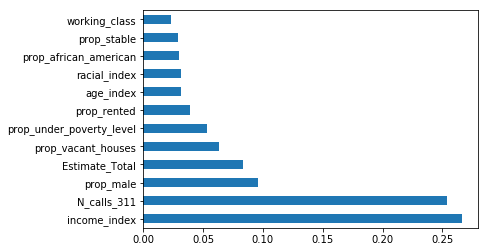

In [44]:
#RF 
from sklearn.metrics import mean_squared_error

rf_tree = RandomForestRegressor(random_state=0)  
rf_tree.fit(X_train, Y_train)  

Y_pred = rf_tree.predict(X_test)
mse_rf = mean_squared_error(Y_test, Y_pred)
print(mse_rf)

feat_importances = pd.Series(rf_tree.feature_importances_, index=x_cols)
feat_importances.nlargest(12).plot(kind='barh')

In [45]:
## normal linear regrression
from  statsmodels.api import OLS
lr = OLS(Y_train,X_train).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_rate   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     1125.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:11:51   Log-Likelihood:                -1426.2
No. Observations:                1365   AIC:                             2876.
Df Residuals:                    1353   BIC:                             2939.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
N_calls_311                  0.0003   1.68e-05     17.930      0.000       0.000       0.000
Estimate_Total              -0.0003   5.58e-05     -4.663      0.000      -0.000      -0.000
prop_rented                  2.3230      1.108      2.096      0.036       0.149       4.497
prop_male                    2.4813      0.369      6.718      0.000       1.757       3.206
prop_african_american       -0.5692      0.205     -2.772      0.006      -0.972      -0.166
prop_under_poverty_level    -3.7033      0.386     -9.582      0.000      -4.461      -2.945
prop_vacant_houses          -0.0931      0.026     -3.633      0.000      -0.143      -0.043
prop_stable                  1.7431      0.302      5.772      0.000       1.151       2.336
racial_index                 0.0002   5.32e-05      3.055      0.002    5.82e-05       0.000
income_index                 0.0002   8.85e-05      2.184      0.029    1.97e-05       0.000
age_index                   -0.0002      0.000     -1.493      0.136      -0.000    6.62e-05
working_class               -0.6712      0.201     -3.347      0.001      -1.065      -0.278
==============================================================================
Omnibus:                      594.611   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9945.450
Skew:                           1.583   Prob(JB):                         0.00
Kurtosis:                      15.839   Cond. No.                     3.28e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.28e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
Y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(Y_test, Y_pred_lr)
print(mse_lr)

0.5423903880558075


### Spatial part taken into consideration

In [47]:
spatial_census = pd.merge(shapefile, yearly_data2, left_on='GEOID10', right_on='GEOID', how='inner')
spatial_census.head(5)

,STATEFP10,COUNTYFP10,TRACTCE10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,...,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class,rate,log_rate
0,06,075,016500,165,Census Tract 165,G5020,S,370459,0,+37.7741958,...,0.860973,0.892645,0.312413,0.222361,396,2612.052450,931.67,0.500416,0.130923,-2.033148
1,06,075,016500,165,Census Tract 165,G5020,S,370459,0,+37.7741958,...,0.883288,0.866613,0.274818,0.232052,331,2573.161577,894.45,0.487838,0.121420,-2.108498
2,06,075,016500,165,Census Tract 165,G5020,S,370459,0,+37.7741958,...,0.873209,0.838458,0.222263,0.173248,516,2397.091988,881.33,0.496903,0.128726,-2.050067
3,06,075,016500,165,Census Tract 165,G5020,S,370459,0,+37.7741958,...,0.883343,0.850349,0.202259,0.202307,446,2552.655480,906.67,0.471356,0.164681,-1.803742
4,06,075,016500,165,Census Tract 165,G5020,S,370459,0,+37.7741958,...,0.850527,0.864932,0.223764,0.148609,1071,2915.401259,1019.72,0.487126,0.146881,-1.918133


In [48]:
yearly_data, morans_data = basic_analysis(2010, 2017, 
                                          spatial_census, 
                                          '../../data/', 
                                          'clean_sf_tracts_with_features_specific')

starting year 2010


/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

('WARNING: ', '06075013300', ' is an island (no neighbors)')
('WARNING: ', '06075013200', ' is an island (no neighbors)')
('WARNING: ', '06075012800', ' is an island (no neighbors)')
('WARNING: ', '06075012700', ' is an island (no neighbors)')
('WARNING: ', '06075011200', ' is an island (no neighbors)')
('WARNING: ', '06075011000', ' is an island (no neighbors)')
('WARNING: ', '06075010800', ' is an island (no neighbors)')
('WARNING: ', '06075010700', ' is an island (no neighbors)')
('WARNING: ', '06075010600', ' is an island (no neighbors)')
('WARNING: ', '06075980600', ' is an island (no neighbors)')
('WARNING: ', '06075980501', ' is an island (no neighbors)')
('WARNING: ', '06075010500', ' is an island (no neighbors)')
('WARNING: ', '06075010400', ' is an island (no neighbors)')
('WARNING: ', '06075010300', ' is an island (no neighbors)')
('WARNING: ', '06075010100', ' is an island (no neighbors)')
('WARNING: ', '06075061400', ' is an island (no neighbors)')
('WARNING: ', '060750615

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/libpysal/weights/weights.py:168: UserWarning: There are 90 disconnected observations 
  Island ids: 06075010100, 06075010300, 06075010400, 06075010500, 06075010600, 06075010700, 06075010800, 06075011000, 06075011200, 06075012501, 06075012601, 06075012602, 06075012700, 06075012800, 06075012901, 06075013101, 06075013102, 06075013200, 06075013300, 06075016200, 06075017101, 06075017102, 06075017601, 06075017801, 06075017802, 06075018000, 06075020401, 06075020402, 06075022600, 06075022702, 06075022704, 06075022802, 06075022803, 06075022901, 06075022902, 06075022903, 06075023003, 06075023102, 06075023103, 06075023200, 06075023300, 06075023400, 06075025200, 06075025300, 06075025401, 06075025402, 06075025403, 06075025600, 06075025702, 06075025800, 06075025900, 06075026001, 06075026002, 06075026003, 06075026004, 06075026200, 06075026301, 06075026302, 06075026303, 06075026401, 06075026402, 06075026403, 06075026404,

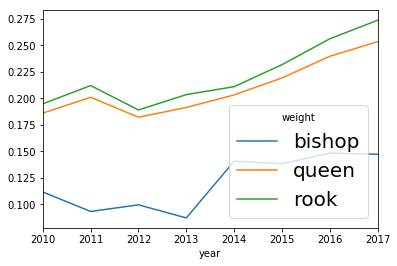

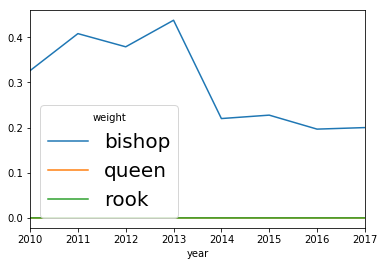

In [49]:
pd.pivot_table(morans_data, values='moran_i', columns='weight', index='year').plot()
pd.pivot_table(morans_data, values='moran_p', columns='weight', index='year').plot()

In [50]:
## limit just 2016 and use 2017
def complex_model(year, cols, weight='qW'):
    tmp_data = yearly_data[year]['data']
    y = np.array(tmp_data['log_rate'])
    y = np.resize(y, [len(y), 1])
    x = np.array(tmp_data[cols])
    qW = yearly_data[year][weight]
    model = spreg.OLS(y, x, w=qW, name_y='log rate change', 
                      name_x=cols,
                      name_ds='censusdata')
    return(model)
    
m_complex = complex_model(2016, x_cols)
print(m_complex.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :  censusdata
Weights matrix      :     unknown
Dependent Variable  :log rate change                Number of Observations:         195
Mean dependent var  :     -2.0447                Number of Variables   :          13
S.D. dependent var  :      0.9413                Degrees of Freedom    :         182
R-squared           :      0.6060
Adjusted R-squared  :      0.5800
Sum squared residual:      67.736                F-statistic           :     23.3248
Sigma-square        :       0.372                Prob(F-statistic)     :    8.07e-31
S.E. of regression  :       0.610                Log likelihood        :    -173.598
Sigma-square ML     :       0.347                Akaike info criterion :     373.197
S.E of regression ML:      0.5894                Schwarz criterion     :     415.746

--------------------------------------------------------------------------

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/pysal/model/spreg/user_output.py:456: UserWarning: w must be API-compatible pysal weights object
  warn("w must be API-compatible pysal weights object")


In [51]:
X_test_pysal = X_test
X_test_pysal['intercept'] = 1
X_test_pysal = np.array(X_test_pysal.reindex(['intercept'] + x_cols, axis=1))
Y_preds_pysal = X_test_pysal.dot(m_complex.betas)
mse_lr_spy = mean_squared_error(Y_test, Y_preds_pysal)
print(mse_lr_spy)

0.3431458806140638


In [52]:
## sdkfs
X_train2016 = yearly_data2.query('year==2016')[x_cols]
Y_train2016 = yearly_data2.query('year==2016')['log_rate']
lr2016 = OLS(Y_train2016,X_train2016).fit()
lr2016.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_rate   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     201.3
Date:                Wed, 17 Apr 2019   Prob (F-statistic):           1.61e-98
Time:                        15:11:56   Log-Likelihood:                -176.13
No. Observations:                 195   AIC:                             376.3
Df Residuals:                     183   BIC:                             415.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
N_calls_311                  0.0002   2.43e-05      9.836      0.000       0.000       0.000
Estimate_Total              -0.0001      0.000     -0.955      0.341      -0.000       0.000
prop_rented                 -0.9231      2.960     -0.312      0.755      -6.763       4.917
prop_male                    1.8222      0.922      1.976      0.050       0.002       3.642
prop_african_american        0.6628      0.570      1.163      0.246      -0.462       1.788
prop_under_poverty_level    -3.0040      0.961     -3.125      0.002      -4.900      -1.107
prop_vacant_houses          -0.0565      0.055     -1.023      0.308      -0.165       0.052
prop_stable                  1.3119      0.842      1.558      0.121      -0.349       2.973
racial_index                 0.0002      0.000      1.670      0.097   -3.74e-05       0.000
income_index             -3.246e-05      0.000     -0.155      0.877      -0.000       0.000
age_index                   -0.0003      0.000     -0.897      0.371      -0.001       0.000
working_class               -1.3149      0.522     -2.518      0.013      -2.345      -0.285
==============================================================================
Omnibus:                       84.862   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              765.507
Skew:                           1.374   Prob(JB):                    5.92e-167
Kurtosis:                      12.309   Cond. No.                     4.09e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
Y_pred_lr = lr2016.predict(X_test.drop('intercept', axis=1))
mse_lr2 = mean_squared_error(Y_test, Y_pred_lr)
print(mse_lr2)

0.35492290804118914
